<a href="https://colab.research.google.com/github/juanfranbrv/curso-langchain/blob/main/Agente%20con%20tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr

# Importar la librería `userdata` de Google Colab.
# Esta librería se utiliza para acceder a datos de usuario almacenados de forma segura en el entorno de Colab.
from google.colab import userdata

# Obtener las claves API de diferentes servicios desde el almacenamiento seguro de Colab.
OPENAI_API_KEY=userdata.get('OPENAI_API_KEY')
# GROQ_API_KEY=userdata.get('GROQ_API_KEY')
# GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
# HUGGINGFACEHUB_API_TOKEN=userdata.get('HUGGINGFACEHUB_API_TOKEN')

# El flag `-qU` instala en modo silencioso (`-q`) y actualiza las librerías si ya están instaladas (`-U`).
%pip install langchain -qU  # Instalar la librería principal de LangChain.
%pip install langgraph -qU

# Instalar las integraciones de LangChain con diferentes proveedores de LLMs.
%pip install langchain-openai -qU
# %pip install langchain-groq -qU
# %pip install langchain-google-genai -qU
# %pip install langchain-huggingface -qU

# Importar las clases necesarias de LangChain para crear plantillas de prompt.
# `ChatPromptTemplate` es la clase base para plantillas de chat.
from langchain.prompts import ChatPromptTemplate


# Importamos las clases necesarias para trabajar con cadenas
from langchain.chains import LLMChain

# Importar las clases para interactuar con los diferentes LLMs a través de LangChain.
from langchain_openai import ChatOpenAI
# from langchain_groq import ChatGroq
# from langchain_google_genai import ChatGoogleGenerativeAI
# from langchain_huggingface import HuggingFaceEndpoint

# Importamos la libreria para formatear mejor la salida
from IPython.display import Markdown, display

# Para la anotacion de tipos
from typing import Literal

# Agente con tools 1

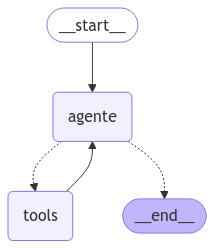

================================ Human Message =================================

Cuantas veces se menciona fresa en la frase: Una fresa es de color fresa
================================== Ai Message ==================================
Tool Calls:
  frecuencia_palabra (call_sBt3iE3GEfWYJylTd3pYchiG)
 Call ID: call_sBt3iE3GEfWYJylTd3pYchiG
  Args:
    texto: Una fresa es de color fresa
    palabra: fresa
================================= Tool Message =================================
Name: frecuencia_palabra

2
================================== Ai Message ==================================

La palabra "fresa" se menciona 2 veces en la frase "Una fresa es de color fresa".


In [2]:
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from langchain.agents import tool


from IPython.display import Image, display


# 1. DEFINIMOS EL ESQUEMA DEL ESTADO ===========================================
# Siempre es algun tipo de diccionario

class MyState(MessagesState):
    # Hereda de MessagesState, que internamente guarda "messages"
    # messages: list[AnyMessage]
    # Podemos añadir campos extra si queremos
    pass

# 2. INSTANCIAMOS UN GRAFO =====================================================
# Lo hacemos pasándole el tipo del estado al constructor

grafo = StateGraph(MyState)

# 3. CREAMOS LAS HERRAMIENTAS / FUNCIONES AUXILIARES ===========================
# Funciones para nodos, arista condicionales y herramientas

# Definir las herramientas
@tool
def contiene_numeros(texto: str) -> bool:
    """Verifica si el texto contiene números."""
    return any(caracter.isdigit() for caracter in texto)

@tool
def contar_caracteres(texto: str) -> int:
    """Cuenta el número total de caracteres en un texto, incluyendo espacios."""
    return len(texto)

@tool
def contar_caracteres_sin_espacios(texto: str) -> int:
    """Cuenta el número de caracteres en un texto, excluyendo espacios."""
    return len(texto.replace(" ", ""))

@tool
def frecuencia_palabra(texto: str, palabra: str) -> int:
    """Cuenta cuántas veces aparece una palabra específica en un texto."""
    return texto.lower().split().count(palabra.lower())

@tool
def frecuencia_letra(texto: str, letra: str) -> int:
    """Cuenta cuántas veces aparece una letra específica en un texto."""
    return texto.lower().count(letra.lower())

# Esta funcion es un nodo
# Recibe el estado e invoca al LLM con los mensajes
def agente(state: MyState) -> MyState:
   return {"messages": [modelo_con_herramientas.invoke(state["messages"])]}

# 4. INSTANCIAMOS EL MODELO Y LE AÑADIMOS LAS HERRAMIENTAS =====================

herramientas = [contiene_numeros,
                contar_caracteres,
                contar_caracteres_sin_espacios,
                frecuencia_palabra,
                frecuencia_letra]

modelo = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY, temperature=0)

modelo_con_herramientas = modelo.bind_tools(herramientas)


# 5. AÑADIMOS NODOS AL GRAFO ===================================================
# Usamos la sintaxis graph.add_node(nombre, runnable)
# nombre: el nombre del nodo
# runnable: función o un ejecutable LCEL que se llamará al entrar al nodo
# Esta función/LCEL debe aceptar un diccionario en el mismo formato que el ESTADO como entrada
# Y devolver un diccionario tambien con el mismo formato que el estado, que sera el nuevo estado.

# Añadimos el nodo y su arista en el grafo
grafo.add_node("agente", agente)
grafo.add_node("tools", ToolNode(herramientas))

# Toolcondition redirecciona a un nodo por defcto que se tiene que llmar tools


# 5. LÓGICA Y ARISTAS ==========================================================
# El nodo inicial lo definimos haciendo uso de START

grafo.add_edge(START, "agente")

# Las aristas condicionales se definen usando el método
# add_conditional_edges (nodo_origen, funcion)
# La funcion de condicion se encarga de decidir (basandose en el estado) el nodo siguiente
# DeBe devolver el nombre del nodo destino (str)

grafo.add_conditional_edges("agente",tools_condition)
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END


# Cualquier arista no condicional la creamos
# grafo.add(nodo1, nodo2)

grafo.add_edge("tools", "agente")

# 6. COMPILAMOS EL GRAFO =======================================================
# Esto crea un LangChain Runnable
# lo que implica que lo podemos usar como cualquier otro Runnable
app = grafo.compile()

# Show
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

# 7. EJECUTAMOS EL RUNNABLE ====================================================
pregunta = "Cuantas veces se menciona fresa en la frase: Una fresa es de color fresa"
respuesta = app.invoke({"messages": pregunta})
for m in respuesta['messages']:
    m.pretty_print()






# Refs
# https://github.com/olonok69/LLM_Notebooks/blob/main/langchain/langgraph/LangGraph_agent_memory.ipynb
# https://anderfernandez.com/blog/sistemas-de-agente-con-langgraph/
# https://github.com/langchain-ai/langgraph/tree/main
# https://blog.langchain.dev/langgraph/

# Agente con tools 2

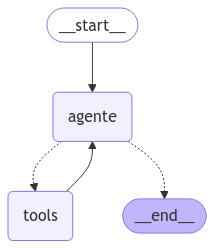

================================ System Message ================================


Eres un asistente al cliente. Cuando recibas una pregunta intenta determinar a que departamento de nuestra empresa dirigir al cliente.
Escoje entre estos: Finanzas, Recursos Humanos, IT, Marketing, Ventas, Logística, Producción, Calidad, Compras, Legal, Investigación,
Desarrollo, Atención al Cliente, Relaciones Públicas, Gestión de Proyectos, Innovación, Administración, Seguridad, Auditoría, Sostenibilidad

Si no puedes determinarlo proporciona la información de Atención al cliente.

================================ Human Message =================================

Que modelo de dron me recomendarian comprar de su catalogo
================================== Ai Message ==================================

Parece que tu consulta está relacionada con la compra de un dron, lo que sugiere que deberías contactar al departamento de Ventas. Permíteme obtener la información de contacto para que puedas comunicarte c

In [3]:
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from langchain.agents import tool


from IPython.display import Image, display


# 1. DEFINIMOS EL ESQUEMA DEL ESTADO ===========================================
# Siempre es algun tipo de diccionario

class MyState(MessagesState):
    # Hereda de MessagesState, que internamente guarda "messages"
    # messages: list[AnyMessage]
    # Podemos añadir campos extra si queremos
    pass

# 2. INSTANCIAMOS UN GRAFO =====================================================
# Lo hacemos pasándole el tipo del estado al constructor

grafo = StateGraph(MyState)

# 3. CREAMOS LAS HERRAMIENTAS / FUNCIONES AUXILIARES ===========================
# Funciones para nodos, arista condicionales y herramientas

# Definir las herramientas
@tool
def obtener_contacto_por_area(area: str) -> tuple:
    """
    Dado el nombre de un área, devuelve (nombre_de_contacto, telefono).
    Si el área no existe, devuelve (None, None).
    """
    # Diccionario con 20 áreas de la empresa.
    contactos = {
        "Finanzas": ["Carlos Pérez", "555-1234"],
        "Recursos Humanos": ["Laura Gómez", "555-5678"],
        "IT": ["Miguel Rivera", "555-9876"],
        "Marketing": ["Ana López", "555-4321"],
        "Ventas": ["Jorge Martínez", "555-2468"],
        "Logística": ["Carmen Ortega", "555-1357"],
        "Producción": ["Luis Hernández", "555-8642"],
        "Calidad": ["Marta Fernández", "555-9753"],
        "Compras": ["Elena Sánchez", "555-6248"],
        "Legal": ["Rafael Domínguez", "555-8475"],
        "Investigación": ["Paula Torres", "555-4826"],
        "Desarrollo": ["Daniel Álvarez", "555-3971"],
        "Atención al Cliente": ["Lucía Moreno", "555-7412"],
        "Relaciones Públicas": ["Raúl Díaz", "555-3698"],
        "Gestión de Proyectos": ["Sandra Gutiérrez", "555-2581"],
        "Innovación": ["Diego Serrano", "555-8524"],
        "Administración": ["Claudia Vega", "555-4869"],
        "Seguridad": ["Andrés Navarro", "555-6547"],
        "Auditoría": ["Patricia Ruiz", "555-7539"],
        "Sostenibilidad": ["Fernando López", "555-1593"]
    }

    # Buscar el área en el diccionario.
    if area in contactos:
        nombre, telefono = contactos[area]
        return (nombre, telefono)
    else:
        return (None, None)

# Esta funcion es un nodo
# Recibe el estado e invoca al LLM con los mensajes
def agente(state: MyState) -> MyState:
   return {"messages": [modelo_con_herramientas.invoke(state["messages"])]}

# 4. INSTANCIAMOS EL MODELO Y LE AÑADIMOS LAS HERRAMIENTAS =====================

herramientas = [obtener_contacto_por_area,]

modelo = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY, temperature=0)

modelo_con_herramientas = modelo.bind_tools(herramientas)


# 5. AÑADIMOS NODOS AL GRAFO ===================================================
# Usamos la sintaxis graph.add_node(nombre, runnable)
# nombre: el nombre del nodo
# runnable: función o un ejecutable LCEL que se llamará al entrar al nodo
# Esta función/LCEL debe aceptar un diccionario en el mismo formato que el ESTADO como entrada
# Y devolver un diccionario tambien con el mismo formato que el estado, que sera el nuevo estado.

# Añadimos el nodo y su arista en el grafo
grafo.add_node("agente", agente)
grafo.add_node("tools", ToolNode(herramientas))

# Toolcondition redirecciona a un nodo por defcto que se tiene que llmar tools


# 5. LÓGICA Y ARISTAS ==========================================================
# El nodo inicial lo definimos haciendo uso de START

grafo.add_edge(START, "agente")

# Las aristas condicionales se definen usando el método
# add_conditional_edges (nodo_origen, funcion)
# La funcion de condicion se encarga de decidir (basandose en el estado) el nodo siguiente
# DeBe devolver el nombre del nodo destino (str)

grafo.add_conditional_edges("agente",tools_condition)
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END


# Cualquier arista no condicional la creamos
# grafo.add(nodo1, nodo2)

grafo.add_edge("tools", "agente")

# 6. COMPILAMOS EL GRAFO =======================================================
# Esto crea un LangChain Runnable
# lo que implica que lo podemos usar como cualquier otro Runnable
app = grafo.compile()

# Show
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

# 7. EJECUTAMOS EL RUNNABLE ====================================================
mensaje_de_sistema = """
Eres un asistente al cliente. Cuando recibas una pregunta intenta determinar a que departamento de nuestra empresa dirigir al cliente.
Escoje entre estos: Finanzas, Recursos Humanos, IT, Marketing, Ventas, Logística, Producción, Calidad, Compras, Legal, Investigación,
Desarrollo, Atención al Cliente, Relaciones Públicas, Gestión de Proyectos, Innovación, Administración, Seguridad, Auditoría, Sostenibilidad

Si no puedes determinarlo proporciona la información de Atención al cliente.
"""
pregunta_del_usuario = "Quiero devolver un producto que esta defectuoso"
pregunta_del_usuario = "Un empleado de ustedes a tenido un comportamiento incorrecto"
pregunta_del_usuario = "Que modelo de dron me recomendarian comprar de su catalogo"
# pregunta_del_usuario = "Quiero proponerles una idea de negocio"
# pregunta_del_usuario = "Que es Streamlit?"

# Creando el estado inicial con MessagesState
estado_inicial = MessagesState(
    messages=[
        ("system", mensaje_de_sistema),
        ("user", pregunta_del_usuario)
    ]
)

# Ejecutando el grafo
respuesta = app.invoke(estado_inicial)
for m in respuesta['messages']:
    m.pretty_print()






# Refs
# https://github.com/olonok69/LLM_Notebooks/blob/main/langchain/langgraph/LangGraph_agent_memory.ipynb
# https://anderfernandez.com/blog/sistemas-de-agente-con-langgraph/
# https://github.com/langchain-ai/langgraph/tree/main
# https://blog.langchain.dev/langgraph/